# Gaussian Processes made Easy

I've been reading about Gaussian proccesses and Ithought I'd share what I've learned. This introduction is on the technical side but hopefully still accessible. The gist should be clear even without  

Gaussian processes are Bayesian non-parametric models which can be used for regression and classification, but this article will focus on regression.

In supervised learning, we have some training data $\mathbf{X}$ and $\mathbf{y}$ and assume the outputs were produced from the inputs by a function $y=f(x)$. In a Bayesian approach, we use the training data to infer the distribution over functions, $p(f|,\mathbf{X}^{\checkmark},\mathbf{y}^{\checkmark})$, then use this to make predictions given new inputs $\mathbf{x_{*}}^{\checkmark}$ by integrating over all functions $f$: 

$$p(y_{*}|\mathbf{x_{*}^{\checkmark}},\mathbf{X}^{\checkmark},\mathbf{y}^{\checkmark}) = \int p(y_{*}\vert f,\mathbf{x_{*}}^{\checkmark})p(f|\mathbf{X}^{\checkmark},\mathbf{y}^{\checkmark})df$$

The use check marks $\checkmark$ to indicate that the variable is known. This is a trick from my high school physics teacher and it's very useful. 

The usual regression approach is to assume some parametric form of the function $f$. For example, linear regression assumes that $f$ follows normal distribution with mean $\mathbf{w}^{T}\mathbf{x}$ and variance $\sigma^2$: 

$$p(y_{*}|\mathbf{x_{*}^{\checkmark}},\theta^{\checkmark})=\mathcal{N}(y_{*}|\mathbf{w}^{T\checkmark}\mathbf{x}_{*}^\checkmark,\sigma^{2\checkmark})$$

The parameters of the distribution, $\theta$ are the weights $\mathbf{w}$ and $\sigma^2$. While assuming parametric representations of the function $f$ is one approach, Gaussian processes provide a way to perform Bayesian inference over the functions $f$ themselves, without assuming any paramatric form of the distribution. Thus instead of inferring $p(\theta|\mathbf{X},\mathbf{y})$, we can infer over the functions themselves: $p(f|\mathbf{X},\mathbf{y})$.

This is a suprising statement. While it is clear to picture a distribution over the values of some parameters, it is less clear to picture *a distribution over functions*. However, we actual only need to be able to define the distribution of the function at some finite, but arbitrary, set of points $\mathbf{x}_1\dots \mathbf{x}_N$, instead of the whole domain of $f(\mathbf{x})$. This is highly convenient, and in fact makes the whole inference possible. It relies on the key assumptions that the function at the set of the values is distributed according to a multivariate Gaussian. This defines a **Gaussian process**, or **GP**:

$$p(f(\mathbf{x}_1)\dots f(\mathbf{x}_N)) \sim \mathcal{N}(\mathbf{x}|\mathbf{\mu}(\mathbf{x}),\mathbf{\mathcal{\Sigma}}(\mathbf{x}))$$

This is simply a multivariate Gaussian distribution, except the mean function $\mathbf{\mu}(\mathbf{x})$ and covariance function $\mathbf{\mathcal{\Sigma}}(\mathbf{x})$ are functions of the data points, which we chose. Notice that it is necessary to choose the points $\mathbf{x}_1\dots \mathbf{x}_N$ to define our probability density, instead of using infinitely many points, and these points in turn determine the mean and covariance functions. This fact will be used later on.

It is important to note that...

## Note on Multivariate Gaussians

Gaussian processes are useful largely because of the nice properties of the multivariate Gaussian (MVN) distribution. Specifically, it is useful that the conditional distribution of a joint Gaussian distribution is also a Gaussian. This is a powerful property. Stated mathematically, suppose the vector-valued random variables $x_A$ and $x_B$ are jointly Gaussian:

$$
\begin{pmatrix}
x_A \\
x_B
\end{pmatrix}
\sim \mathcal{N}{\left(
\begin{pmatrix}
\mu_A \\
\mu_B
\end{pmatrix}
,
\begin{pmatrix}
\Sigma_{AA} & \Sigma_{AB}\\
\Sigma_{AB}^{T} & \Sigma_{BB}\\
\end{pmatrix}
\right)}
$$

where $\mu_A, \mu_B$ are the corresponding means and $\Sigma_{A}, \Sigma_{AB}, \Sigma_{AB}^{T}, \Sigma_{BB}$ are the corresponding covariance matrices. Notice that $x_A$ and $x_B$ are simply vectors that would be obtained by splitting one larger vector $x$ i.e. $x$ is the concatenation of $x_A$ and $x_B$.

Here is the **key property**. When you condition one variable on another, the resulting distribution is also a Gaussian:

$$p(x_A|x_B)=\mathcal{N}(x_A|\mu_{*},\Sigma_{*})$$

where the new mean and covariance are given by
$$\mu_{*} = \mu_A + \Sigma_{AB}\Sigma_{BB}^{-1}(x_B-\mu_B)$$

$$\Sigma_{*} = \Sigma_{AA} - \Sigma_{AB}\Sigma_{BB}^{-1}\Sigma_{AB}^T$$

Thus the resulting distribution is a Gaussian with mean and covariance calculated simply from the means and covariances of the joint distribution. While this is a nice result, deriving the equations for $\mu_{*}$ and $\Sigma_{*}$ involve some intense linear algebra and I go into it. This conditional distribution is essential for our GP regression example below.

## Coveriance

Before starting the regression example, it should be noted that the covariance $\Sigma(x)$ will be given by $\Sigma_{ij}=\kappa(x_i,x_j)$ where $\kappa$ is a positive definite kernel function, which measures the similarity between the two points. The kernel is designed to capture the notion that if two points $x_i$ and $x_j$ are close to each other, or similar, then so should the outputs $f(x_i)$ and $f(x_j)$. This is encoded in the covariance matrix.

## GP Regression

Now it's time to demonstrate GP regression in action. First, let's choose the test points $\mathbf{X}_{*}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# number of data points
n = 50

# create the data points
x_s = np.linspace(-5,5, n).reshape(-1,1)

Now let's sample the prior to get a sense of the function $f$ at these points:

$$p(f_{*}|X_{*})=\mathcal{N}(f_{*}| \mu_{*},K_{**})$$

where
$\mu = 0$ by design and $K = \kappa(X_{*},X_{*})$, which is simply a covariance matrix, which is defined by the data, which we selected. I chose the x-values to have mean 0 because the mean plays a very minor role and it simplifies the calculations. The covariance matrix is far more important. Let's samples some values to see how $f$ prior behaves over the x-values that we selected.

In [3]:
# First, we need to define the covariance function (RBF kernel)
def kernel(a, b, param=0.1):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

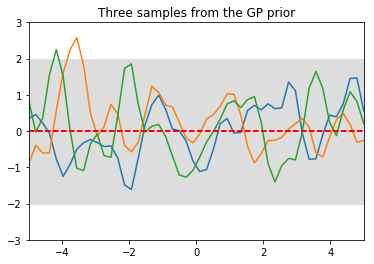

In [19]:
# Find the mean and covariance of the x-values
mu_s = np.repeat(0,n).reshape(n,1) # by assumption
K_ss = kernel(x_s, x_s)

# From each of the 50 points, take 5 samples from our prior
f_s_prior = np.random.multivariate_normal(mu_s[:,0], K_ss, size=(3)).T

# find the standard deviation to demonstrate the prediction uncertainty
s2_prior = np.diag(K_ss)
stdv_prior = (s2_prior**0.5).reshape(n,1)

plt.plot(x_s,f_s_prior)
plt.gca().fill_between(x_s.flat, (mu_s-2*stdv_prior)[:,0], (mu_s+2*stdv_prior)[:,0], color="#dddddd")
plt.plot(x_s, mu_s, 'r--', lw=2)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP prior')
plt.show()

The function output $f$ at each $x$ value is normally distributed with mean zero and variance defined by $K_{**}$ (the meaning of the double stars will become clear shortly). The grey region indicates a 2 standard deviation region for the prediction of $f$. The uncertainty is contant across all points $x$, reflecting the fact that in the prior, $f(x_i)$ at each point $x_i$ follows the same distribution. 

The covariance encodes how correlated different values of $f(x_i)$ are with each other. The kernel captures the notion that for values $x_i$ that are close to each other, $f(x_i)s$ should also be close to each other, resulting in a smooth function. The kernel can be tuned to increase or decrease the smoothness.

Notice that this is much different from the, say, linear regression setting, where each output $f(x_i)$ was independent of each other. In this setting, the $f(x_i)'s$ are correlated as given in the covariance matrix.

Now, 6 data points are observed and the posterior predictive distribution is updated. The data points are noise-less observations of the true function, a sine function. The prior distribution

$$p(f_{*}|X_{*}^{\checkmark})$$

becomes the posterior predictive distribution after observing data $X$ and $f$:

$$p(f_{*}|X_{*}^{\checkmark},X^{\checkmark},f^{\checkmark})= ?$$

By the asusmptions of a GP, the function at the 50 test points, $f_{*}$, and at the 6 observed outputs $f^{\checkmark}$ form a joint Gaussian distribution:

$$
\begin{pmatrix}
f^{\checkmark} \\
f_{*}
\end{pmatrix}
\sim \mathcal{N}{\left(
\begin{pmatrix}
\mu^{\checkmark} \\
\mu_{*}^{\checkmark}
\end{pmatrix}
,
\begin{pmatrix}
K^{\checkmark} & K_{*}^{\checkmark}\\
K_{*}^{T\checkmark} & K_{**}^{\checkmark}\\
\end{pmatrix}
\right)}
$$

where $f$ and all means and covariances are known since they are functions of the data $X^{\checkmark}$ and $X_{*}^{\checkmark}$, which are also known.

Now, we use the helpful property of Gaussians by conditioning on the data points that we observed:

$$p(f_{*}|X_{*}^{\checkmark},X^{\checkmark},f^{\checkmark})= \mathcal{N}(\mu_{post},K_{post})$$

where $\mu_{post}$ and $K_{post}$ are given by:
$$\mu_{post} = \mu_{*} + K_{*}^{T}K^{-1}(f-\mu)$$

$$K_{post} = K_{**} - K_{*}^{T}K^{-1}K_{*}$$

All values on the right hand side are known, so we're done! **We now have the predictive posterior distrbution - all that's left is to sample from it.** The fact that the function values form a joint Gaussian allowed us to use the nice property to condition on the observed values. Now that we have everything we need, let's sample from the posterior and plot it.

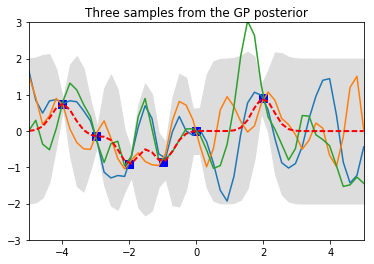

In [8]:
# observe 6 points of training data
x = np.array([-4,-3,-2,-1,0,2]).reshape(6,1)
f = np.sin(x)

# apply the kernel function to get the covariance
K = kernel(x,x)  # K
K_s = kernel(x,x_s)  # K_*
K_ss = K_ss # we already calculated this before from x_s
K_i = np.linalg.inv(K)  # inverse of K

# find the new parameters, using the property of conditional joint Gaussians
mu_post = mu_s + np.dot(K_s.T,K_i).dot(f)
K_post = K_ss - np.dot(K_s.T,K_i).dot(K_s)

# use the parameters to sample from the posterior distribution
# From each of the 50 points, take 6 samples from our prior
f_s_post = np.random.multivariate_normal(mu_post[:,0], K_post, size=(3)).T

# find the standard deviation to demonstrate the prediction uncertainty
s2_post = np.diag(K_post)
stdv_post = (s2_post**0.5).reshape(n,1)

# Plot the function
plt.plot(x, f, 'bs', ms=8)
plt.plot(x_s,f_s_post)
plt.gca().fill_between(x_s.flat, (mu_post-2*stdv_post)[:,0], (mu_post+2*stdv_post)[:,0], color="#dddddd")
plt.plot(x_s, mu_post, 'r--', lw=2)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP posterior')
plt.show()

By conditioning on the 6 known data points, the posterior collapsed around the data points, as desired, since we know these are the true values. The uncertainty, shown by the grey region, becomes smaller near the data points and larger away from them.